Image Caption Generator Project


In [ ]:
#Importing all the necessary libraries
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import nltk
from nltk.translate.bleu_score import corpus_bleu

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Importing Keras libraries to perform image captioning
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.xception import Xception
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import plot_model

#This helps us to view the progress
from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

In [ ]:
#Mounting google drive to retrieve flickr dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We start by defining all the functions that are needed to perform various operations in our code such as


1.   Data Collection and preparation
2.   Feature extraction as 2048 feature vector
3.   Model definition
4.   Model training
5.   Evaluation (here BLEU score)



In [ ]:
#Simple function to open files
def document_loader(filename):
    opened_file = open(filename, 'r')
    text = opened_file.read()
    opened_file.close()
    return text

#Function to append images and captions into descriptions dictionary
def imgs_and_captions(filename):
    doc_text = document_loader(filename)
    captions = doc_text.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Text cleaning
def text_cleaning(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            des = img_caption.split()

            des = []
            for word in des:
                des.append(word.lower())
            new_des = []
            for word in des:
                new_des.append(word.translate(table))
            des = new_des
            new_des = []
            for word in des:
                if len(word) > 1 and word.isalpha():
                    new_des.append(word)
            des = new_des
            img_caption = ' '.join(des)
            captions[img][i]= img_caption
    return captions

#Vocab set
def text_vocabulary(descriptions):
    vocabulary = set()
    for key in descriptions.keys():
        for description in descriptions[key]:
            words = description.split()
            for word in words:
                vocabulary.add(word)
    return vocabulary

#Saving descriptions
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for description in desc_list:
            lines.append(key + '\t' + description )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
#Preprocessing and extracting feature vector
def features_extract(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for image in tqdm(os.listdir(directory)):
            filename = directory + "/" + image
            img = Image.open(filename)
            img = img.resize((299,299))
            img = np.expand_dims(img, axis=0)

            img = img/127.5
            img = img - 1.0

            feature = model.predict(img)
            features[image] = feature
        return features
#Loading photos data
def photos_load(filename):
    file = document_loader(filename)
    photos = file.split("\n")[:-1]
    return photos

#Clean descriptions
def clean_desc_load(filename, photos):
    file = document_loader(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()

        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions

#Loading feature vector
def features_load(photos):
    all_features = load(open("features.p","rb"))
    features = {}
    for k in photos:
        features[k] = all_features[k]
    return features
#Transforming dictionary to list containing clean descriptions
def convert_dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        for key in descriptions:
            for d in descriptions[key]:
                all_desc.append(d)
    return all_desc

#Creating and saving tokens
def create_and_save_tokenizer(descriptions):
    desc_list = convert_dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
#Data generation
def generate_data(descriptions, features, tokenizer, max_desc_length):
    while True:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequence_pairs(tokenizer, max_desc_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

#Creating sequence pairs
def create_sequence_pairs(tokenizer, max_desc_length, desc_list, feature):
    X1, X2, y = list(), list(), list()

    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_desc_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
#Captioning model function
def define_captioning_model(vocab_size, max_desc_length):

    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_desc_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model
#Max length
def calculate_max_length(descriptions):
    desc_list = convert_dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_description(model, tokenizer, photo, max_description_length):
    in_text = 'start'
    for i in range(max_description_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_description_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

#This function tries to preprocess the image and extract features
def extract_image_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("error for opening image")
        return None
    image = image.resize((299, 299))
    image = np.array(image)
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature
#Captions generator function
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        prediction = model.predict([photo, sequence], verbose=0)
        prediction = np.argmax(prediction)
        word = word_for_id(prediction, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

#Ground truth captions
def read_ground_truth_captions(file_path):
    captions = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                image_path, caption = parts
                if image_path not in captions:
                    captions[image_path] = []
                captions[image_path].append(caption)
            else:
                print(f"Skipping invalid line: {line.strip()}")
    return captions

#Evaluation metric BLEU score
def calculate_bleu_score(model, tokenizer, max_length, ground_truth_file,photo):
    ground_truth_captions = read_ground_truth_captions(ground_truth_file)
    hypotheses, references = [], []

    for image_path, gt_captions in ground_truth_captions.items():
        generated_caption = generate_caption(model, tokenizer,photo, max_length)
        hypotheses.append(generated_caption.split())
        references = []
        for caption in gt_captions:
            references.append(caption.split())


    bleu_score = corpus_bleu(references, hypotheses)

    return bleu_score

In [ ]:
#Text dataset and image dataset paths
text_dataset = "/content/drive/MyDrive/cap_gen/Flickr8k_text"
images_dataset = "/content/drive/MyDrive/cap_gen/Flickr8k_Dataset/Flicker8k_Dataset"

filename = text_dataset + "/" + "Flickr8k.token.txt"

descriptions = imgs_and_captions(filename)
clean_descriptions = text_cleaning(descriptions)
vocabulary = text_vocabulary(clean_descriptions)

print("Length of descriptions =" ,len(descriptions))
print("Length of vocabulary = ", len(vocabulary))

#Saving captions for each image
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  0


In [ ]:
#Feature vector creation
features = features_extract(images_dataset)
dump(features, open("features.p","wb"))

In [ ]:
#Loading feature vector
features = load(open("features.p","rb"))

In [ ]:
filename = text_dataset + "/" + "Flickr_8k.trainImages.txt"

#Loading training images and respective descriptions
train_imgs = photos_load(filename)
train_descriptions = clean_desc_load("descriptions.txt", train_imgs)
train_features = features_load(train_imgs)

In [ ]:
tokenizer = create_and_save_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size
max_desc_length= calculate_max_length(descriptions)
[a,b],c = next(generate_data(train_descriptions, features, tokenizer, max_desc_length))
a.shape, b.shape, c.shape

Training the model based on the extracted features and saving the model for every epoch

In [ ]:
print('Length of dataset: ', len(train_imgs))
print('Training descriptions:', len(train_descriptions))
print('Training pics:', len(train_features))
print('Size of vocabulary', vocab_size)
print('Length of description: ', max_desc_length)

captioning_model = define_captioning_model(vocab_size, max_desc_length)

epochs = 20
steps = len(train_descriptions)

models_dir = "models"
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

#Training the model and saving model for each epoch
for i in range(epochs):
    generator = generate_data(train_descriptions, train_features, tokenizer, max_desc_length)
    captioning_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    try:
      captioning_model.save("models/model_" + str(i) + ".h5")
    except Exception as e:
      print("Error while saving model:", i)


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 32, 256)              1939712   ['input_4[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_3[0][0]'] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1422/6000 [======>.......................] - ETA: 5:11 - loss: 3.7821

In [ ]:
!pip install pydot

Displaying output of the model for generating captions for the given image

1/1 [==============================] - 2s 2s/step



start brown dog is running through the water end


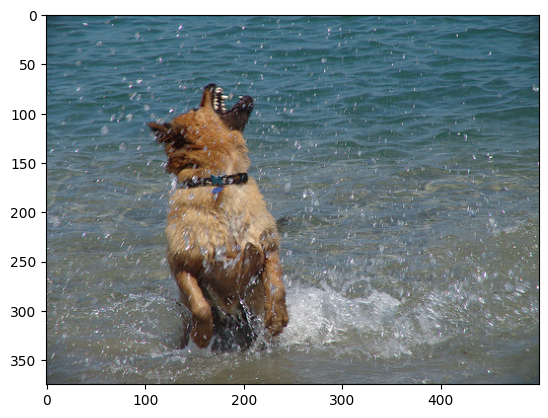

In [ ]:
img_path = r'/content/drive/MyDrive/cap_gen/Flickr8k_Dataset/Flicker8k_Dataset/1287982439_6578006e22.jpg'  # replace with your image file path

max_length = 32
tokenizer = load(open("/content/tokenizer.p", "rb"))
loaded_model = load_model('/content/models/model_14.h5')
xception_model = Xception(include_top = False, pooling = "avg")

photo_features = extract_image_features(img_path, xception_model)
description = generate_description(loaded_model, tokenizer, photo_features, max_length)

print("\n\n")
print(description)
img = Image.open(img_path)
plt.imshow(img)
plt.show()

Evaluating the training model using BLEU score

In [ ]:

xception_model = Xception(include_top = False, pooling = "avg")
image_features  = extract_image_features(img_path, xception_model)
tokenizer = load(open("/content/tokenizer.p", "rb"))
loaded_model = load_model('/content/models/model_0.h5')
maximum_length = 32
ground_truth_file = '/content/descriptions.txt'
b_score = calculate_bleu_score(loaded_model, tokenizer, maximum_length, ground_truth_file,image_features )
print("BLEU Score : ", b_score )


BLEU Score is: 0.663
